# Visual-Area Autolabeler: Training

## About

[Noah C. Benson](mailto:nben@uw.edu)$^{1,2,3}$, [Shaoling Chen](mailto:sc6995@nyu.edu)$^{4}$, and [Jonathan Winawer](mailto:jonathan.winawer@nyu.edu)$^{1,2}$

$^1$Department of Psychology  
$^2$Center for Neural Sciences  
$^4$Courant Institute for Mathematics  
New York University  
New York, NY 10012

$^3$**Current Affiliation:**  
eScience Institute  
University of Washington  
Seattle, WA 98195

## Configuration

Here we define any configuration item that needs to be set locally for the system running this notebook. Most likely, you will have to edit these in order for the model to work correctly.

In [1]:
# data_cache_path
# The directory into which data for the model training should be cached. This
# can be None, but if it is, then the training images will need to be
# regenerated every time the notebook is run.
data_cache_path  = '/data/visual-autolabel/data'

# model_cache_path
# The directory into which to store models that are generated during training.
# This may be None, but if it is, then the best models will not be saved out to
# disk during rounds of training.
model_cache_path = '/data/visual-autolabel/models'

# tract_path
# The directory in which tractography data for the subjects is stored.
tract_path = '/data/hcp/tracts'

## Initialization

### Libraries

In [2]:
import os, sys, pimms, pandas, json
import numpy as np
import scipy as sp
import nibabel as nib
import pyrsistent as pyr
import neuropythy as ny
import torch, torchvision, torchsummary

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv

import visual_autolabel as va

In [3]:
%matplotlib inline

In [4]:
# Additional matplotlib preferences; these are just display preferences.
mpl_font_config = {'family':'sans-serif',
                   'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
                   'size': 10,
                   'weight': 'light'}
mpl.rc('font', **mpl_font_config)
# We want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*4
mpl.rcParams['savefig.dpi'] = 72*8

### Utilities

In [5]:
train_until_features = {'Anatomical Data Only':         'anat',
                        'Functional Data Only':         'func',
                        'Tractography Data Only':       'tract',
                        'Anatomical & Functional Data': 'both'}
def train_until(training_plan,
                until=None, model_key=None,
                partition=None,
                features=None,
                model_cache_path=model_cache_path,
                data_cache_path=data_cache_path,
                tract_path=tract_path,
                create_directories=True,
                create_mode=0o755,
                logger=print):
    """Continuously runs the given training plan for models until an interrupt.
        
    Runs training on `'anat'`, `'func'`, and `'both'` models, sequentially,
    using random partitions until a keyboard interrupt is caught, at which
    point a `pandas` dataframe of the results is returned. The partition is
    generated only once per group of model trainings (i.e., per training of an
    anatomical, functional, and combined model).
    
    Parameters
    ----------
    training_plan : list of dicts
        The training-plan to pass to the `visual_autolabel.run_modelplan()`
        function.
    model_key : str or None, optional
        A string that should be appended, as a sub-directory name, to the
        `model_cache_path`; this argument allows one to save model training
        to a specific sub-directory of the `model_cache_path` directory.
    partition : partition-like or None
        The partition to use. If `None`, then a new partition is drawn for
        every set of rounds of training.
    features : dict-like or None
        The features that should be used in training. If `None` (the default),
        then the dictionary `train_until_features` is used. Otherwise,
        `features` must be a dict-like object whose keys are the names of the
        feature-set and whose values are the features to pass to the training
        routine.
    model_cache_path : str, optional
        The cache-path to use for the model training. By default, this is the
        global variable `model_cache_path`, defined above.
    data_cache_path : str, optional
        The cache-path from which data for the model training should be loaded.
        By default, this is the global variable `data_cache_path`, defined
        above.
    until : int or None, optional
        If an integer is provided, then only `until` groups of trainings are
        performed, then the result is returned. If `None`, then the training
        continues until a `KeyboardInterrupt` is caught. The default is `None`.
    create_directories : boolean, optional
        Whether to create cache directories that do not exist (default `True`).
    create_mode : int, optional
        What mode to use when creating directories (default: `0o755`).
    logger : function or None, optional
        The logging function to use. If `None`, then nothing is logged. The
        default is `print`.
    """
    import time
    from collections.abc import Mapping
    if data_cache_path is Ellipsis:
        data_cache_path = globals()['data_cache_path']
    if model_cache_path is Ellipsis:
        model_cache_path = globals()['model_cache_path']
    if model_key is not None:
        if model_cache_path is None:
            model_cache_path = model_key
        else:
            model_cache_path = os.path.join(model_cache_path, model_key)
            if create_directories and not os.path.isdir(model_cache_path):
                os.makedirs(model_cache_path, create_mode)
    if features is None: features = train_until_features
    if not isinstance(features, Mapping):
        raise ValueError("features must be a dict-like object or None")
    if not os.path.isdir(model_cache_path) and create_directories:
        os.makedirs(model_cache_path, create_mode)
    if not os.path.isdir(data_cache_path) and create_directories:
        os.makedirs(data_cache_path, create_mode)
    training_history = []
    try:
        if logger: logger('')
        iterno = 0
        while True:
            if until is not None and iterno >= until: break
            iterno += 1
            # Make one partition for all three minimization types.
            if partition is None:
                part = va.partition(va.sids, how=(0.8, 0.2))
            else:
                part = va.partition(va.sids, how=partition)
            pid = va.partition_id(part)
            if logger:
                logger('%-15s%70s' % ('Iteration %d' % iterno,
                                      'Partition ID: %s' % pid))
                logger('=' * 85)
            for (dnm,dtype) in features.items():
                if logger:
                    logger('')
                    logger(dnm + ' ' + '-'*(85 - len(dnm) - 1))
                    logger('')
                if isinstance(dtype, Mapping) and len(dtype) == 1:
                    dtype_nm = next(iter(dtype.keys()))
                else:
                    dtype_nm = dtype
                t0 = time.time()
                (model, loss, dice) = va.train.run_modelplan(
                    training_plan,
                    partition=part,
                    features=dtype,
                    model_cache_path=None,
                    data_cache_path=data_cache_path,
                    tract_path=tract_path,
                    logger=logger)
                t1 = time.time()
                row = dict(input=dtype_nm, loss=loss, dice=dice,
                           training_time=(t1-t0))
                # See if this one is good enough that it needs to be saved.
                hh = [d for d in training_history if d['input'] == dtype_nm]
                if model_cache_path is not None and len(hh) > 0:
                    mn = sorted(hh, key=lambda d:d['dice'])[0]
                    if mn['dice'] > dice:
                        # We need to save out this model!
                        savepath = os.path.join(model_cache_path,
                                                f"best_{dtype_nm}.pt")
                        torch.save(model.state_dict(), savepath)
                training_history.append(row)
                if logger: logger('')
    except KeyboardInterrupt:
        if logger:
            logger('')
            logger('KeyboardInterrupt caught; ending training.')
    training_history = ny.to_dataframe(training_history)
    if model_cache_path is not None:
        ny.save(os.path.join(model_cache_path, "training.tsv"),
                training_history)
    return training_history

In [6]:
def autolog(filename, stdout=True, clear=False,
            create_directories=True, create_mode=0o755):
    """Returns a function that can be used as a logger for the given filename.
    
    `autolog(filename)` returns a function that acts like the `print()`
    function but that writes both to stdout and to the given file.
    
    Parameters
    ----------
    filename : str
        The name of the file to which to log any text.
    stdout : boolean, optional
        If `True` (the default), then writes any text to stdout as well as to
        the given file; otherwise, writes only to the file.
    clear : boolean, optional
        If `True`, then clears the file before returning; otherwise, the file
        is left as-is, and text is appended (the default).
    create_directories : boolean, optional
        Whether to create cache directories that do not exist (default `True`).
    create_mode : int, optional
        What mode to use when creating directories (default: `0o755`).
    """
    if create_directories:
        (flpath,flnm) = os.path.split(filename)
        if not os.path.isdir(flpath): os.makedirs(flpath, mode=create_mode)
    if clear and os.path.isfile(filename):
        # Truncate the file; don't remove it.
        with open(filename, 'w') as fl: pass
    def logfn(*args):
        with open(filename, 'a') as f:
            print(*args, file=f)
        if stdout:
            print(*args)
    return logfn

In [7]:
def load_training(model_key, model_cache_path=model_cache_path,
                  partition=None):
    """Loads data from a directory written to during `train_until`.
    
    `load_training(model_key)` can be used to load data saved by
    a call to `train_until` with the given `model_key`.
    
    Parameters
    ----------
    model_key : str
        The model key used to save the `train_until` results.
    model_cache_path : str, optional
        The cache path in which the models are saved. By default
        uses `model_cache_path` (the gloabl value).
        
    Returns
    -------
    tuple
        A tuple `(history, models)` of the training history, as
        a PANDAS dataframe, and the best models for each input type
        as a dict.
    """
    import torch
    path = os.path.join(model_cache_path, model_key)
    hist_path = os.path.join(path, 'training.tsv')
    hist = ny.load(hist_path) if os.path.isfile(hist_path) else None
    mdls = {}
    for fl in os.listdir(path):
        if fl.startswith('best_') and fl.endswith('.pt'):
            flnm = os.path.join(path, fl)
            state = torch.load(flnm)
            nfeat = state['base_model.conv1.weight'].shape[1]
            mdl = va.UNet(nfeat, 6)
            mdl.load_state_dict(state)
            mdls[fl[5:-3]] = mdl
    return (hist, mdls)

In [8]:
def plot_prediction(dataset, k, model,
                    axes=None, figsize=(6,1), dpi=72*4,
                    min_alpha=0.5,
                    channels=(0,1,4,5),
                    round_labels=True):
    """Plots the data, true label, and predicted label (by model) of a dataset.
    
    `plot_prediction(dataset, k, model)` creates a `matplotlib` figure for
    `dataset[k]` (i.e., the `k`th subject/image in `dataset`). The `axes` are
    always returned.
    
    Parameters
    ----------
    dataset : HCPVisualDataset
        The dataset used to plot the predictions. This may alternately be a
        PyTorch dataloader, in which case the dataloader's dataset must be an
        `HCPVisualDataset` object.
    k : int
        The sample number or subject ID to plot. A sample number is just the
        index number for the subject in the dataset; if a number less than 1000
        is given, then it is assumed to eb a subject index, while if it is over
        1000, it is assumed to be a subject ID.
    model : PyTorch Module
        A UNet model or other PyTorch model that makes a segmentation
        of the images from the given `dataset`.
    axes : MatPlotLib axes or `None`, optional
        A set of axes onto which to plot the predictions. Must have a total
        flattened length of 3.
    figsize : tuple, optional
        A tuple of `(width, height)` in inches to use for the figure size. This
        is ignored if `axes` is provided. The default is `(6, 1)`.
    dpi : int, optional
        The number of dots per inch in the output image. If `axes` is provided,
        this option is ignored. The default is `72 * 4`.
    min_alpha : float, optional
        The minimum alpha value to show in the alpha channel of the image.
        Values below this level are replaced by the formula
        `adjusted_value = value * (1 - min_alpha) + min_alpha`. The default is
        `0.5`.
    channels : iterable of ints, optional
        When a dataset whose input images have more than 4 image channels is
        provided (i.e., the `'both'` datasets, which have 4 anatomical and 4
        functional image layers), then this list of 4 channels is used. By
        default this is `(0,1,4,5)`. This option is ignored if the dataset
        contains images with only 4 channels.
    round_labels : boolean, optional
        Whether to round every channel to either 1 or 0 before plotting the
        labels. The default is `True`.
    """
    if k > 1000:
        # We have a subject-ID instead of an index.
        k = np.where(dataset.sids == k)[0]
    (imdat, imlbl) = dataset[k]
    impre = model(imdat[None,:,:,:].float())
    if not model.apply_sigmoid:
        impre = torch.sigmoid(impre)
    impre = dataset.inv_transform(None, impre.detach()[0])
    (imdat, imlbl) = dataset.inv_transform(imdat, imlbl)
    if axes is None:
        (fig,axes) = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    # with imdat we want to adjust the alpha layer
    imdat = np.array(imdat)
    imdat[:,:,3] = imdat[:,:,3]*(1 - min_alpha) + min_alpha
    for (ax,im,rl) in zip(axes, [imdat,imlbl,impre], [0,0,round_labels]):
        if im.shape[2] > 4: im = im[:,:,:4]
        im = np.clip(im, 0, 1)
        if rl:
            z = im < 0.5
            im[z] = 0
            im[~z] = 1
        ax.imshow(im)
        ax.axis('off')
    return axes

In [9]:
def load_inferred(sid, h, path=None, prefix=None):
    """Loads the Bayesian inferred maps for an HCP subject.
    
    This function will load the maps from the given path if it is
    provided, but if not it will load them from the visual
    performance fields OSF database.
    """
    tr = {'polar_angle':'angle',
          'eccentricity': 'eccen',
          'radius': 'sigma',
          'visual_area': 'varea'}
    if path is None:
        pp = ny.data['visual_performance_fields'].pseudo_path
        path = 'inferred_maps'
    else:
        pp = None
    r = {}
    for (k,v) in tr.items():
        flnm = f'{sid}.{h}.inf-MSMAll_{v}.native32k.mgz'
        flnm = os.path.join(path, flnm)
        if pp is not None: flnm = pp.local_path(flnm)
        r[k] = ny.load(flnm)
    if prefix is not None:
        r = {(prefix + k):v for (k,v) in r.items()}
    return r
def add_inferred(sub, path=None, prefix='inf_'):
    """Given an HCP subject, returns a copy with inferred maps.
    
    This function loads the inferred maps for the subject and
    adds them to the left and right hemispheres, then returns
    the subject with those added maps.
    """
    sid = int(sub.name)
    lhdat = load_inferred(sid, 'lh', path=path, prefix=prefix)
    rhdat = load_inferred(sid, 'rh', path=path, prefix=prefix)
    return sub.with_hemi(lh=sub.lh.with_prop(lhdat),
                         rh=sub.rh.with_prop(rhdat))

In [10]:
def add_prior(sub, prefix='prior_'):
    """Given a subject, adds the retinotopic prior and returns it.
    
    This function calculates the retinotopic prior for the subejct,
    adds the prior maps to the subject's hemispheres, and returns
    the new subject.
    """
    tr = {'polar_angle':'angle',
          'eccentricity': 'eccen',
          'radius': 'sigma',
          'visual_area': 'varea'}
    lhdat = ny.vision.predict_retinotopy(sub.lh)
    rhdat = ny.vision.predict_retinotopy(sub.rh)
    (lhdat,rhdat) = [{k:dat[v] for (k,v) in tr.items()}
                     for dat in (lhdat,rhdat)]
    if prefix is not None:
        (lhdat,rhdat) = [
            {(prefix+k):v for (k,v) in dat.items()}
            for dat in (lhdat,rhdat)]
    return sub.with_hemi(lh=sub.lh.with_prop(lhdat),
                         rh=sub.rh.with_prop(rhdat))

In [11]:
def add_anatlabels(sub):
    """Returns a copy of the given subject with anatomist labels.
    """
    lbldata = ny.data['hcp_lines'].subject_labels
    sid = int(sub.name)
    lbls = {}
    for h in ['lh','rh']:
        ll = {}
        for anat in ['A1','A2','A3','A4']:
            lbldat = lbldata[anat].get(sid,{})
            lbldat = lbldat.get(h, {})
            lbldat = lbldat.get('visual_area', None)
            if lbldat is not None:
                ll[f'{anat}_visual_area'] = lbldat
        if len(ll) > 0:
            lbls[h] = ll
    return sub.with_hemi(lh=sub.lh.with_prop(lbls.get('lh', {})),
                         rh=sub.rh.with_prop(lbls.get('rh', {})))

## Training

### Training Plan

First, we define our standard training plan for training models.

In [12]:
training_plan = [
    dict(lr=0.00375, gamma=0.9, num_epochs=10,  bce_weight=0.67),
    dict(lr=0.00250, gamma=0.9, num_epochs=10,  bce_weight=0.33),
    dict(lr=0.00125, gamma=0.9, num_epochs=10,  bce_weight=0.00)]

Additionally, we define a standard set of training and validation subjects. If the files `training_sids.json` and `validate_sids.json` are found in the current directory, they are imported; otherwise, a random partition is made.

In [13]:
if (os.path.isfile('training_sids.json') and
    os.path.isfile('validate_sids.json')):
    with open('training_sids.json', 'r') as fl:
        trn_sids = np.array(json.load(fl))
    with open('validate_sids.json', 'r') as fl:
        val_sids = np.array(json.load(fl))
else:
    (trn_sids, val_sids) = va.partition(va.sids)
    ## The following can be used to save these out to files.
    #with open('training_sids.json', 'w') as fl:
    #    json.dump(trn_sids.tolist(), fl)
    #with open('validate_sids.json', 'w') as fl:
    #    json.dump(val_sids.tolist(), fl)

### Train Continuously

Here, we train the model continuously until an interruption is received (typically a keyboard interruption, which can be sent via the `Kernel > Interrupt Kernel` menu item in Jupyter. This slowly produces a lot of output, but the result, which is returned once the interrupt is sent, will be a `pandas` dataframe of training statistics.

Code to run the training for 50 cycles:

```python
model_key = '2022-05-20'
log_path = os.path.join(model_cache_path, model_key, 'training.log')
hist = train_until(training_plan,
                   until=50,
                   logger=autolog(log_path, clear=True),
                   model_key=model_key,
                   partition=(trn_sids, val_sids))
```

In [ ]:
# If training the standard models:
model_key = 'test_training'
log_path = os.path.join(model_cache_path, model_key, 'training.log')
hist = train_until(training_plan,
                   until=50,
                   logger=autolog(log_path, clear=True),
                   model_key=model_key,
                   partition=(trn_sids, val_sids))

In [ ]:
# If training tractography models, we currently lack data for three
# subjects: 150423, 186949, 239136.
# We just make tract traning and validation subject ids.
tract_trn_sids = np.setdiff1d(trn_sids, [150423, 186949, 239136])
tract_val_sids = val_sids
# If we want to train just the tractography model, we can use this
# as the features argument (using None or omitting it will run the
# tract models interspersed with the anatomical and functional data
# models).
features = {'Tractography Data': 'tract'}

# Run the training.
model_key = 'test_tract_training'
log_path = os.path.join(model_cache_path, model_key, 'training.log')
hist = train_until(training_plan,
                   tract_path=tract_path,
                   features=features,
                   until=50,
                   logger=autolog(log_path, clear=True),
                   model_key=model_key,
                   partition=(tract_trn_sids, tract_val_sids))

### Visualization of Predictions

Note that all (or almost all) of the code below assumes that we aren't using the tractography data/training.

In [11]:
# What model are we loading (should match the model_key from the
# train_until call, in the above cells).
model_key = '2022-05-20'
(hist, models) = load_training(model_key)
# If we need to use a special partition (e.g., for tractography
# datasets), we set these here.
partition = (trn_sids, val_sids)
#partition = (tract_trn_sids, tract_val_sids)

# If we haven't loaded the datasets variable already, let's load it.
if 'datasets' not in locals() or datasets is None:
    datasets = va.make_datasets(partition=(trn_sids, val_sids),
                                cache_path=data_cache_path)

In [234]:
mdl_anat = models['anat']
mdl_func = models['func']
#mdl_tract = models['tract']
ds_anat = datasets['anat']['val']
ds_func = datasets['func']['val']
#ds_tract = datasets['tract']['val']

# Build up the dataset of validation subjects:
valsubjects = {}
for sidx in range(len(ds_func)):
    sid = ds_anat.sids[sidx]
    # Start by making the model predictions:
    flatmaps = {}
    sub = mdl_anat.predict(ds_anat, sidx, prefix='anat',
                           flatmaps=flatmaps)
    sub = mdl_func.predict(ds_func, sidx, prefix='func',
                           flatmaps=flatmaps, subject=sub)
    # Add in the inferred and prior maps.
    sub = add_prior(add_inferred(sub))
    # And the anatomist labels.
    sub = add_anatlabels(sub)
    valsubjects[sid] = sub

In [15]:
def dice_scores(trueprop, predprop, smooth=0):
    """Calculate the per-channel dice-score for a segmentation image.
    
    Returns a dice similarity coefficient for each image channel in the
    `truprop` and `predprop` images.
    """
    dice = []
    for ll in np.unique(trueprop):
        if ll == 0: continue
        tt = (trueprop == ll)
        pp = (predprop == ll)
        isect = np.sum(tt & pp)
        d = (2 * isect + smooth) / (np.sum(tt) + np.sum(pp) + smooth)
        dice.append(d)
    return dice
def dice_score(trueprop, predprop, smooth=0):
    """Calculates the mean-channel dice-score for a segmentation image.
    
    Returns the mean of the `dice_scores(truprop, predprop)`.
    """
    return np.mean(dice_scores(trueprop, predprop, smooth))

In [344]:
prefixes = ['prior','inf','anat','func']
gsprefixes = ['A1','A2','A3','A4']
dice = {}
for h in ['lh','rh']:
    d = []
    for sub in valsubjects.values():
        dd = []
        hem = sub.hemis[h]
        for gspre in gsprefixes:
            gsprop = hem.prop('visual_area')
            ddd = []
            for pre in prefixes:
                p = hem.prop(pre + '_visual_area')
                if pre == 'inf' or pre == 'prior':
                    p = np.array(p)
                    e = hem.prop(pre+'_eccentricity')
                    p[e > 7] = 0
                    p[p > 3] = 0
                ddd.append(dice_scores(gsprop, p))
            dd.append(ddd)
        d.append(np.nanmean(dd, axis=0))
    dice[h] = np.array(d)
lrdice = np.vstack([dice['lh'],dice['rh']])

In [351]:
anatdice = {'lh':[], 'rh':[]}
anats = ['A1','A2','A3','A4']
for sub in valsubjects.values():
    for h in ['lh','rh']:
        hem = sub.hemis[h]
        d = []
        for (aii,a1) in enumerate(anats):
            for a2 in anats[(aii+1):]:
                p1 = a1 + '_visual_area'
                p2 = a2 + '_visual_area'
                if p1 not in hem.properties or p2 not in hem.properties:
                    continue
                p1 = hem.prop(p1)
                p2 = hem.prop(p2)
                dd = dice_scores(p1, p2)
                if len(dd) != 3: continue
                d.append(dd)
        anatdice[h].append(np.nanmean(d, axis=0))
anatdice = {h:np.array(v) for (h,v) in anatdice.items()}
lranatdice = np.vstack([anatdice['lh'], anatdice['rh']])

In [352]:
(anatmean_each, anatse_each) = (
    np.mean(lranatdice, axis=0),
    np.std(lranatdice, axis=0)/np.sqrt(len(lranatdice)))
anatmean_all = np.mean(lranatdice)
anatse_all   = np.std(lranatdice)/np.sqrt(len(lranatdice.flatten()))

In [353]:
(mean_all, std_all) = (np.mean(lrdice, axis=(0,2)),
                       np.std(np.mean(lrdice, axis=2), axis=0))

In [354]:
(mean_each, std_each) = (np.mean(lrdice, axis=(0)),
                         np.std(lrdice, axis=(0)))

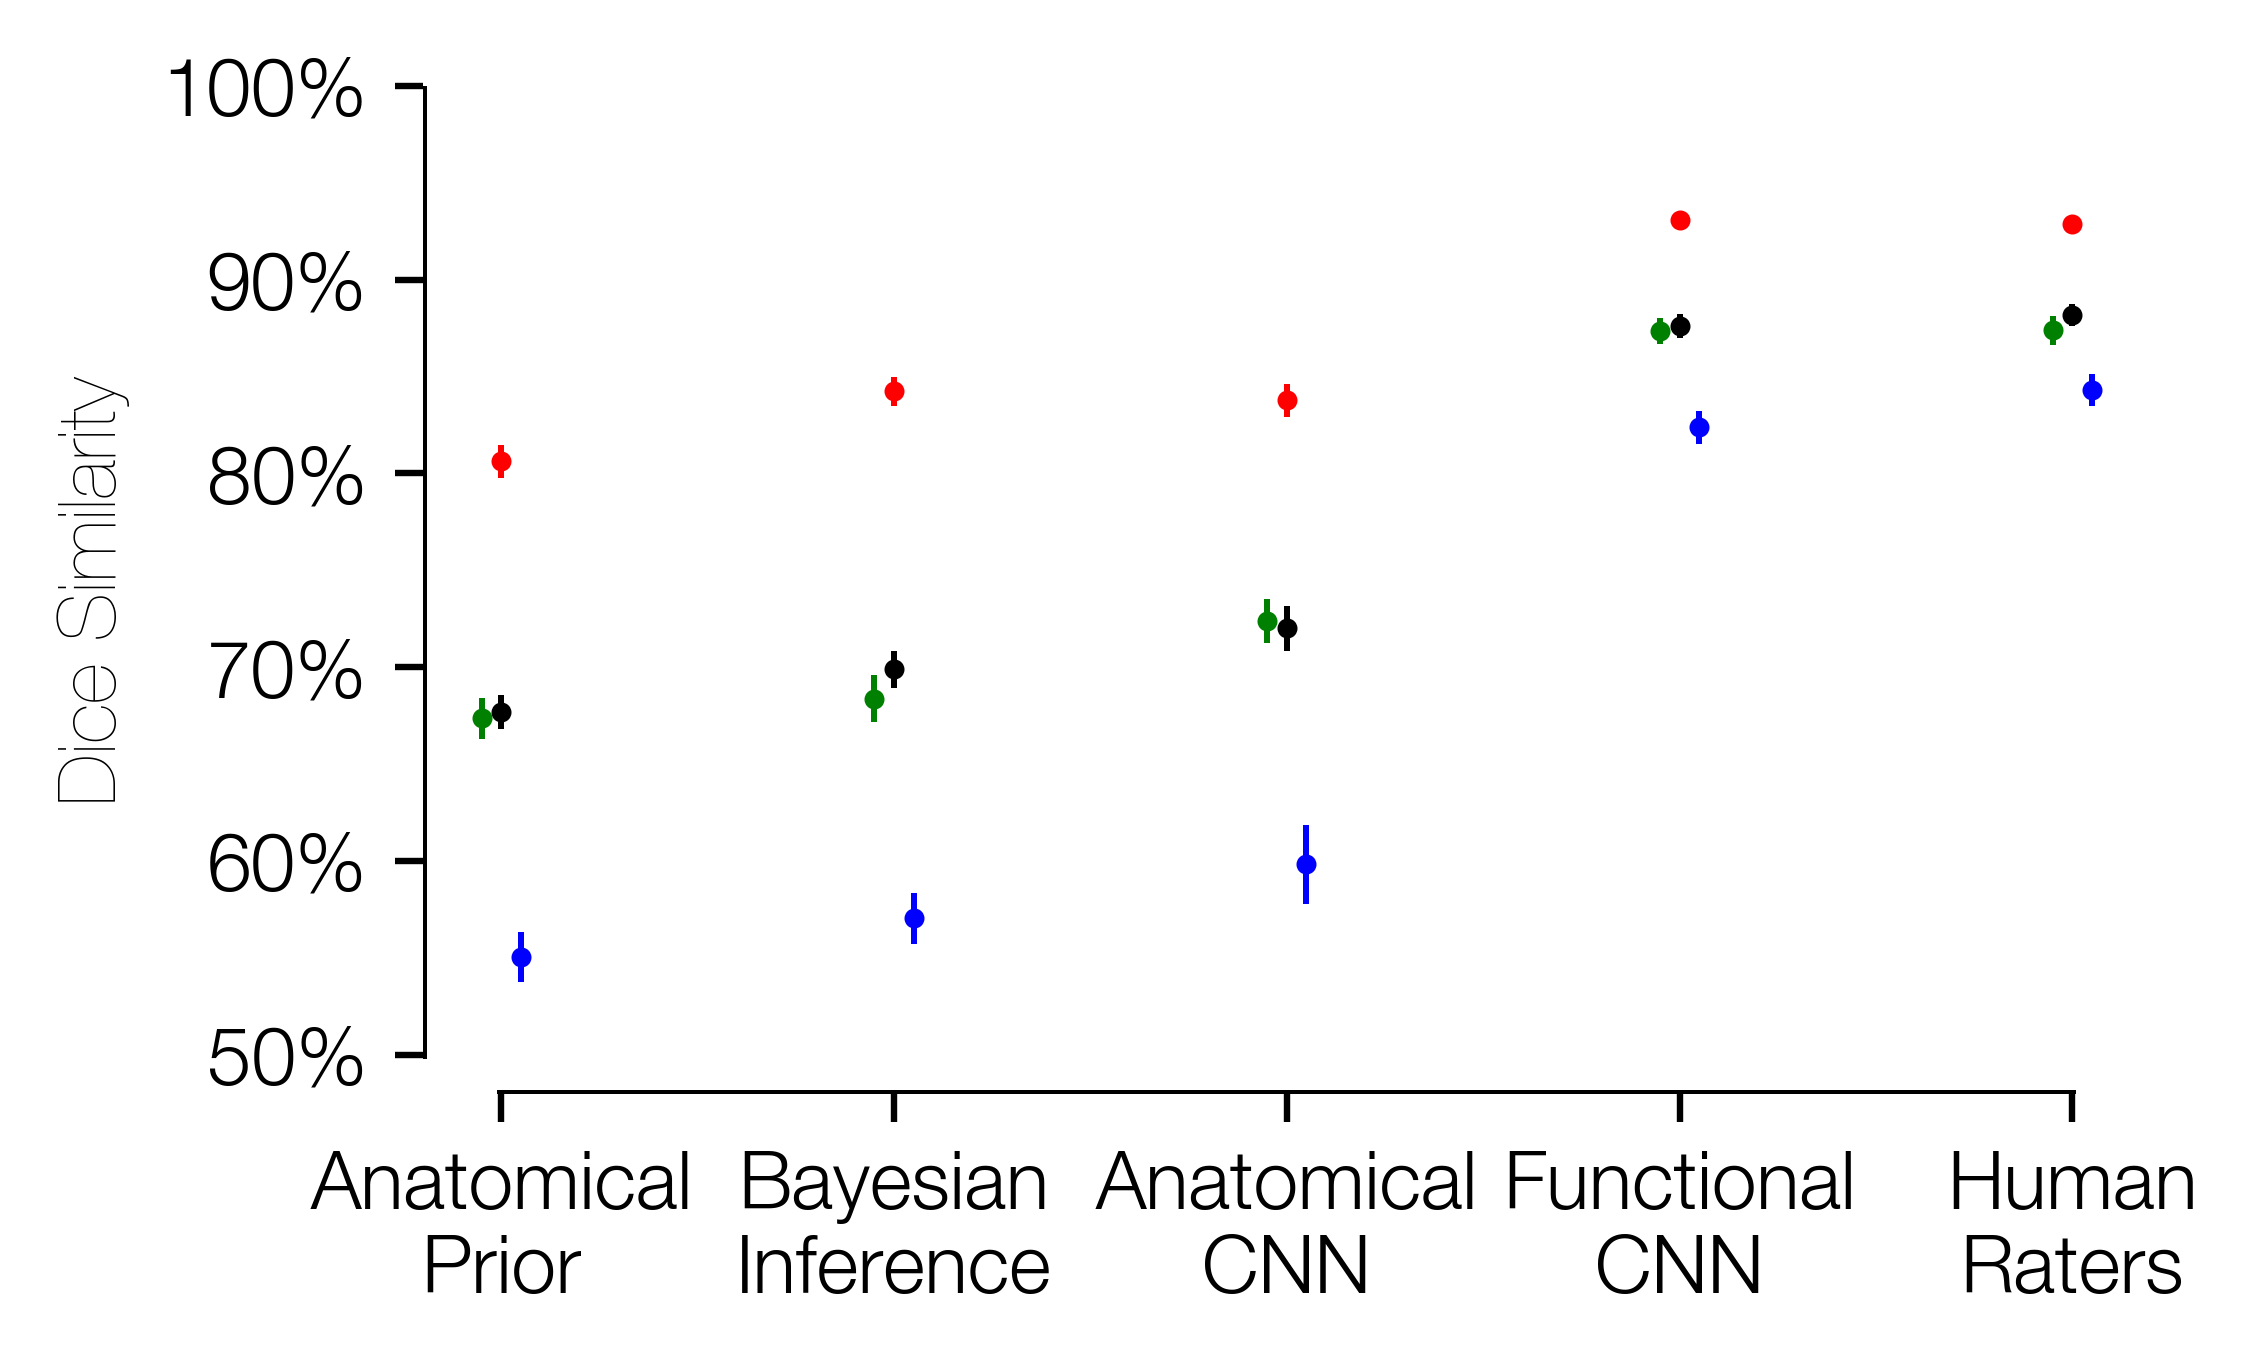

In [355]:
(fig,ax) = plt.subplots(1,1, figsize=(3,1.75), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0,0)

sqrtn = np.sqrt(len(lrdice))
for (ii,(dx,c)) in enumerate(zip([0,-1,1], ['r',(0,0.5,0,1),'b'])):
    dx *= 0.05
    #if ii != 0: continue
    for (k,(mu,std)) in enumerate(zip(mean_each, std_each)):
        (mu,std) = (mu[ii], std[ii])
        ax.plot(k+dx, mu, '.', ms=3, color=c)
        ax.plot([k+dx,k+dx], [mu-std/sqrtn, mu+std/sqrtn], '-', lw=0.75, color=c)
    # Also do the anatomist data.
    (k, mu,se) = (4, anatmean_each[ii], anatse_each[ii])
    ax.plot(k+dx, mu, '.', ms=3, color=c)
    ax.plot([k+dx,k+dx], [mu-se, mu+se], '-', lw=0.75, color=c)
c = 'k'
for (k,(mu,std)) in enumerate(zip(mean_all, std_all)):
    ax.plot(k, mu, '.', ms=3, color=c)
    ax.plot([k,k], [mu-std/sqrtn, mu+std/sqrtn], '-', lw=0.75, color=c)
(k, mu, se) = (4, anatmean_all, anatse_all)
ax.plot(k, mu, '.', ms=3, color=c)
ax.plot([k,k], [mu-se, mu+se], '-', lw=0.75, color=c)

for sp in ax.spines.values(): sp.set_visible(False)
ax.plot([0,4], [0.48,0.48], 'k-', lw=1)
ax.plot([-0.2,-0.2], [0.5,1], 'k-', lw=1)
ax.set_ylim([0.48,1])
ax.set_xlim([-0.2,4.2])
ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels(["50%","60%", "70%", "80%", "90%", "100%"])
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['Anatomical\nPrior', 'Bayesian\nInference',
                    'Anatomical\nCNN',   'Functional\nCNN',
                    'Human\nRaters'])
ax.set_ylabel('Dice Similarity')

pass

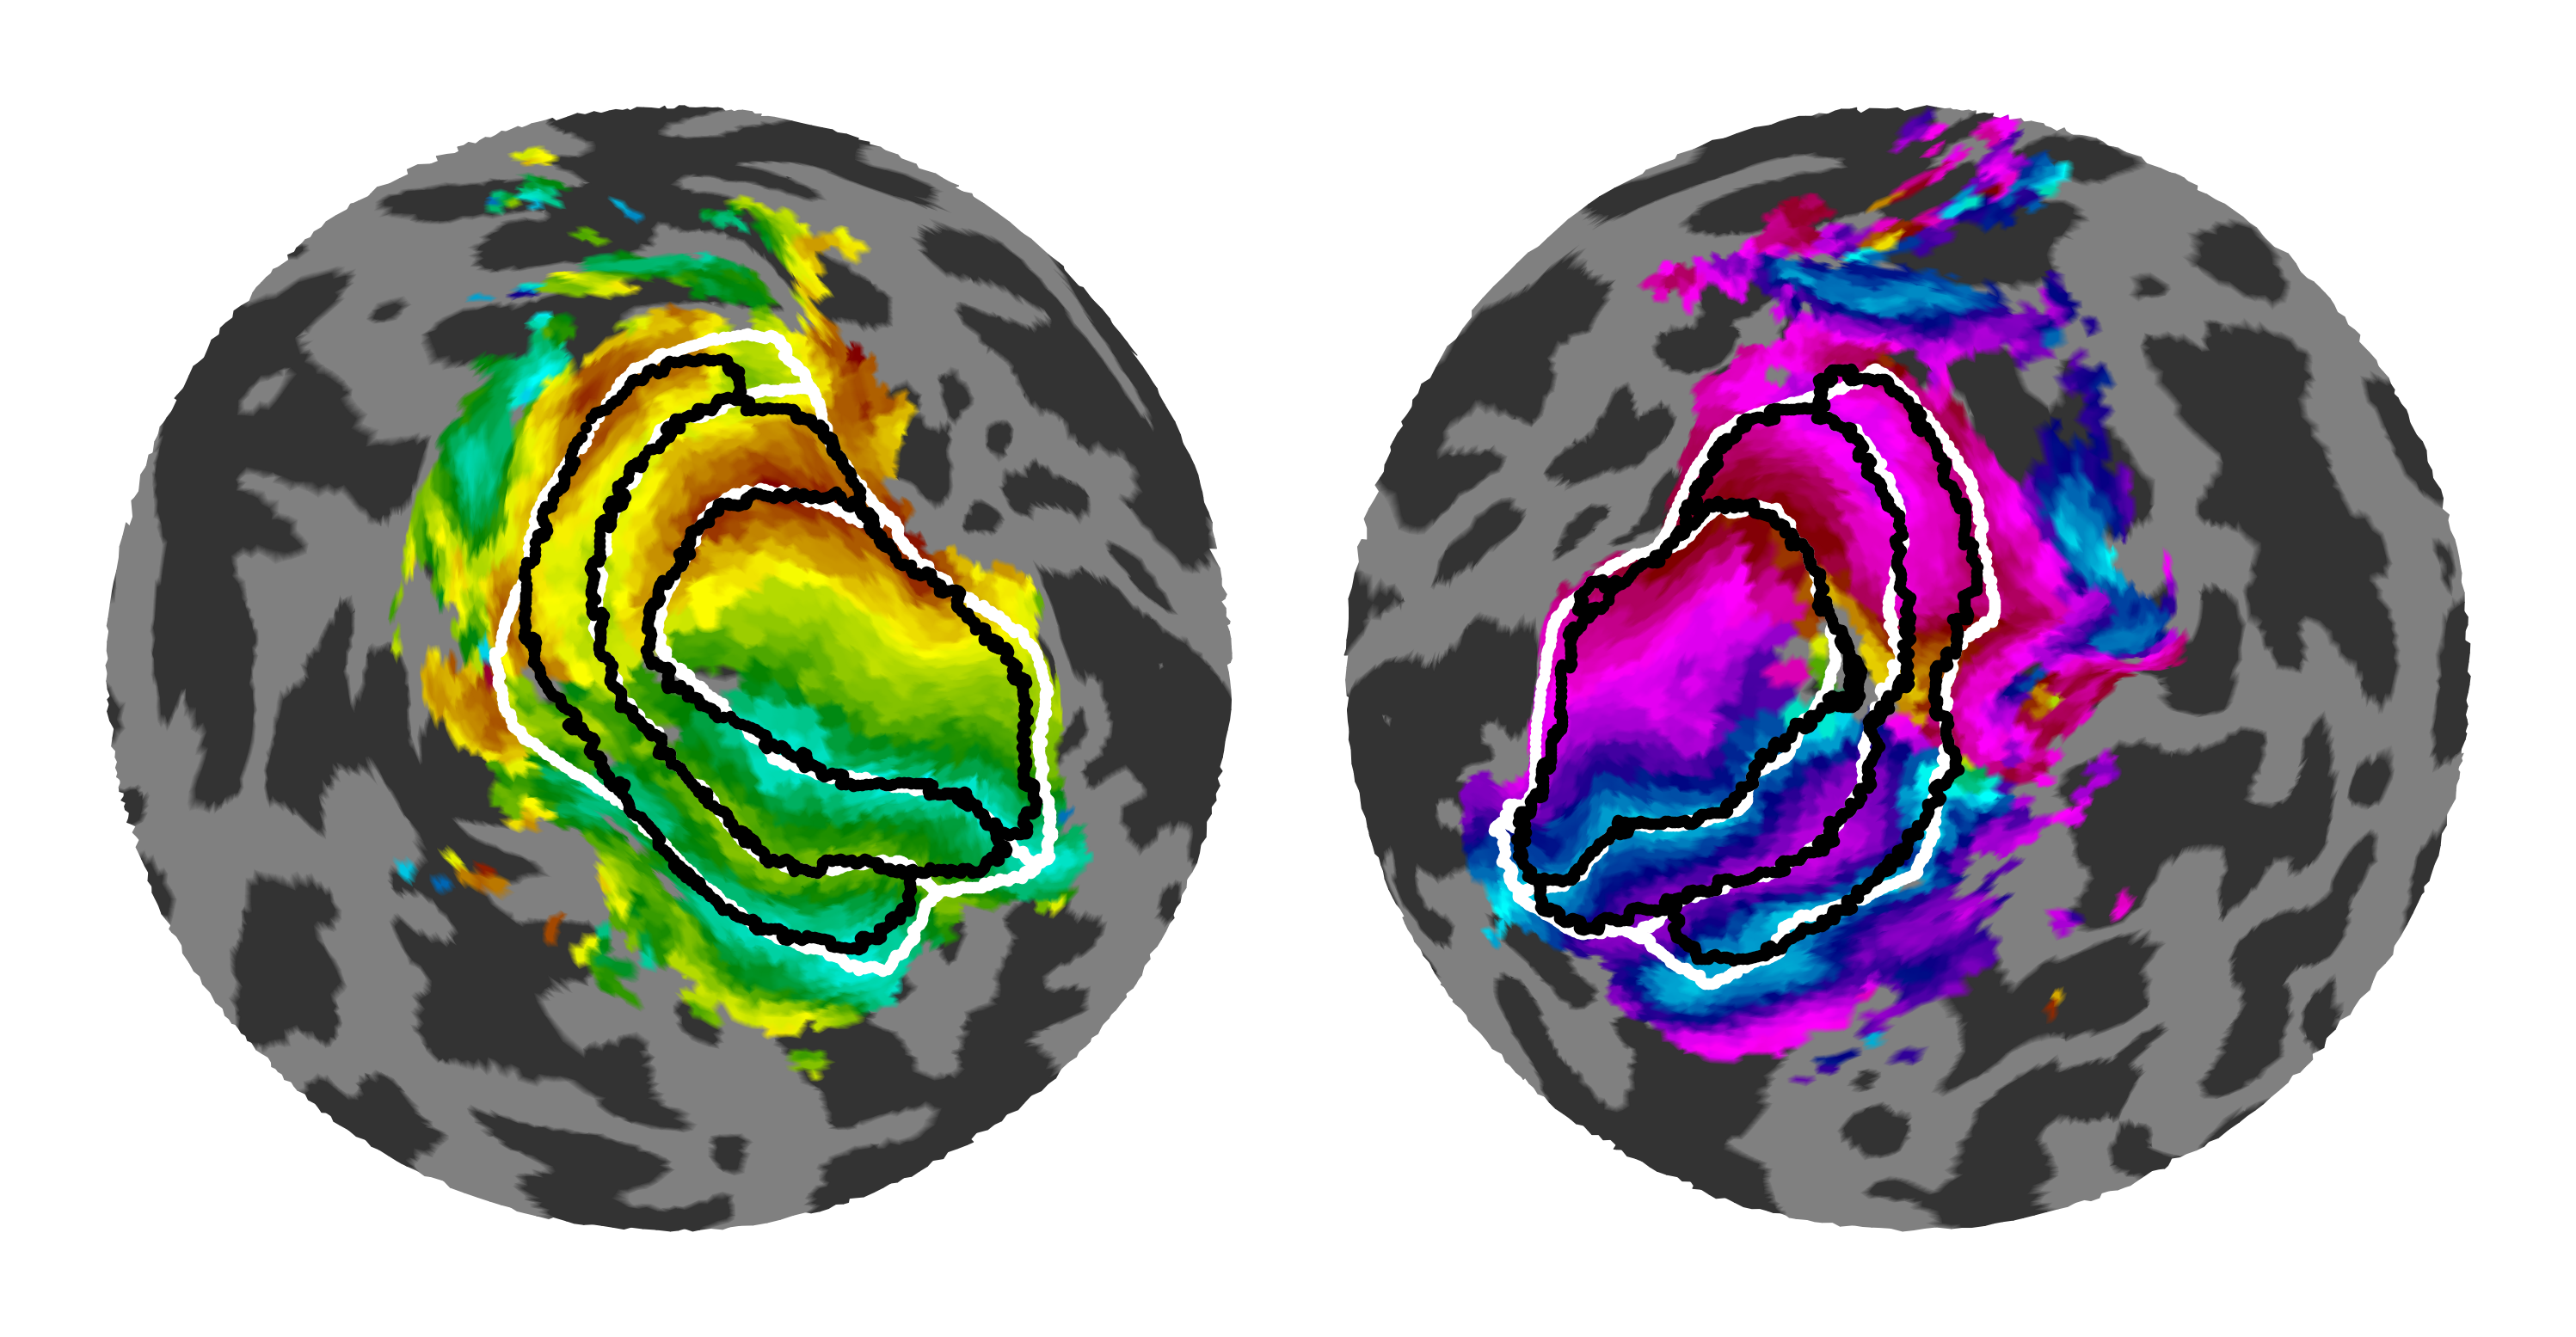

In [343]:
sid = 131217
sub = valsubjects[sid]
fmaps = {h: ny.to_flatmap('occipital_pole', sub.hemis[h])
         for h in ['lh','rh']}

(fig,axs) = plt.subplots(1,2, figsize=(5, 2.5), dpi=72*8)
fig.subplots_adjust(0,0,1,1,0,0)

for (h,ax) in zip(['lh','rh'], axs):
    fmap = fmaps[h]
    ny.cortex_plot(fmap, axes=ax,
                   color='prf_polar_angle',
                   mask=('prf_variance_explained', 0.1, 1))
    # Add lines.
    for (pnm,clr) in zip(['visual_area','func_visual_area'],
                         ['w', 'k']):
        p = fmap.prop(pnm)
        (u,v) = fmap.tess.indexed_edges
        ii = p[u] != p[v]
        xy = fmap.coordinates
        xy = np.mean([xy[:,u[ii]], xy[:,v[ii]]], axis=0)
        ax.scatter(xy[0],xy[1], c=clr, s=0.5)
    # Turn off axes.
    ax.axis('off')

In [329]:
sid = 131217
surf = 'inflated'

rot = {'lh': [0,0,-np.pi/4],
       'rh': [0,0,np.pi/4]}
trl = {'lh': [-50, 0, 0],
       'rh': [50, 0, 0]}
pathdata = ny.data['hcp_lines'].native_paths['mean']

#fig = ipv.figure(width=800,height=400)

sub = valsubjects[sid]
lh = sub.lh.surface(surf).rotate(rot['lh']).translate(trl['lh'])
rh = sub.rh.surface(surf).rotate(rot['rh']).translate(trl['rh'])
fig = ny.cortex_plot(lh, figure=fig,
                     color='prf_polar_angle',
                     mask=('prf_variance_explained', 0.1, 1))
ny.cortex_plot(rh, figure=fig,
               color='prf_polar_angle',
               mask=('prf_variance_explained', 0.1, 1))

lines = {'iso_angle': ['V1_ventral','V1_dorsal',
                       'V2_ventral','V2_dorsal',
                       'V3_ventral','V3_dorsal'],
         'iso_eccen': ['7']}
for (k,lns) in lines.items():
    for ln in lns:
        for h in ['lh','rh']:
            from neuropythy.geometry.util import rotation_matrix_3D
            pdat = pathdata[sid][h][k][ln]
            xyz = pdat.coordinates[surf]
            (pitch,roll,yaw) = rot[h]
            rm = np.dot(np.dot(rotation_matrix_3D([1,0,0], pitch),
                               rotation_matrix_3D([0,1,0], roll)),
                    rotation_matrix_3D([0,0,1], yaw))
            xyz = np.dot(rm, xyz)
            xyz = xyz + np.array(trl[h])[:,None]
            (x,y,z) = xyz
            ipv.scatter(x, y, z, color='black', size=0.4)
        
#ipv.show()
fig

Figure(camera=PerspectiveCamera(fov=0.644570721372708, matrixWorldNeedsUpdate=True, position=(0.0, -100.0, 0.0…

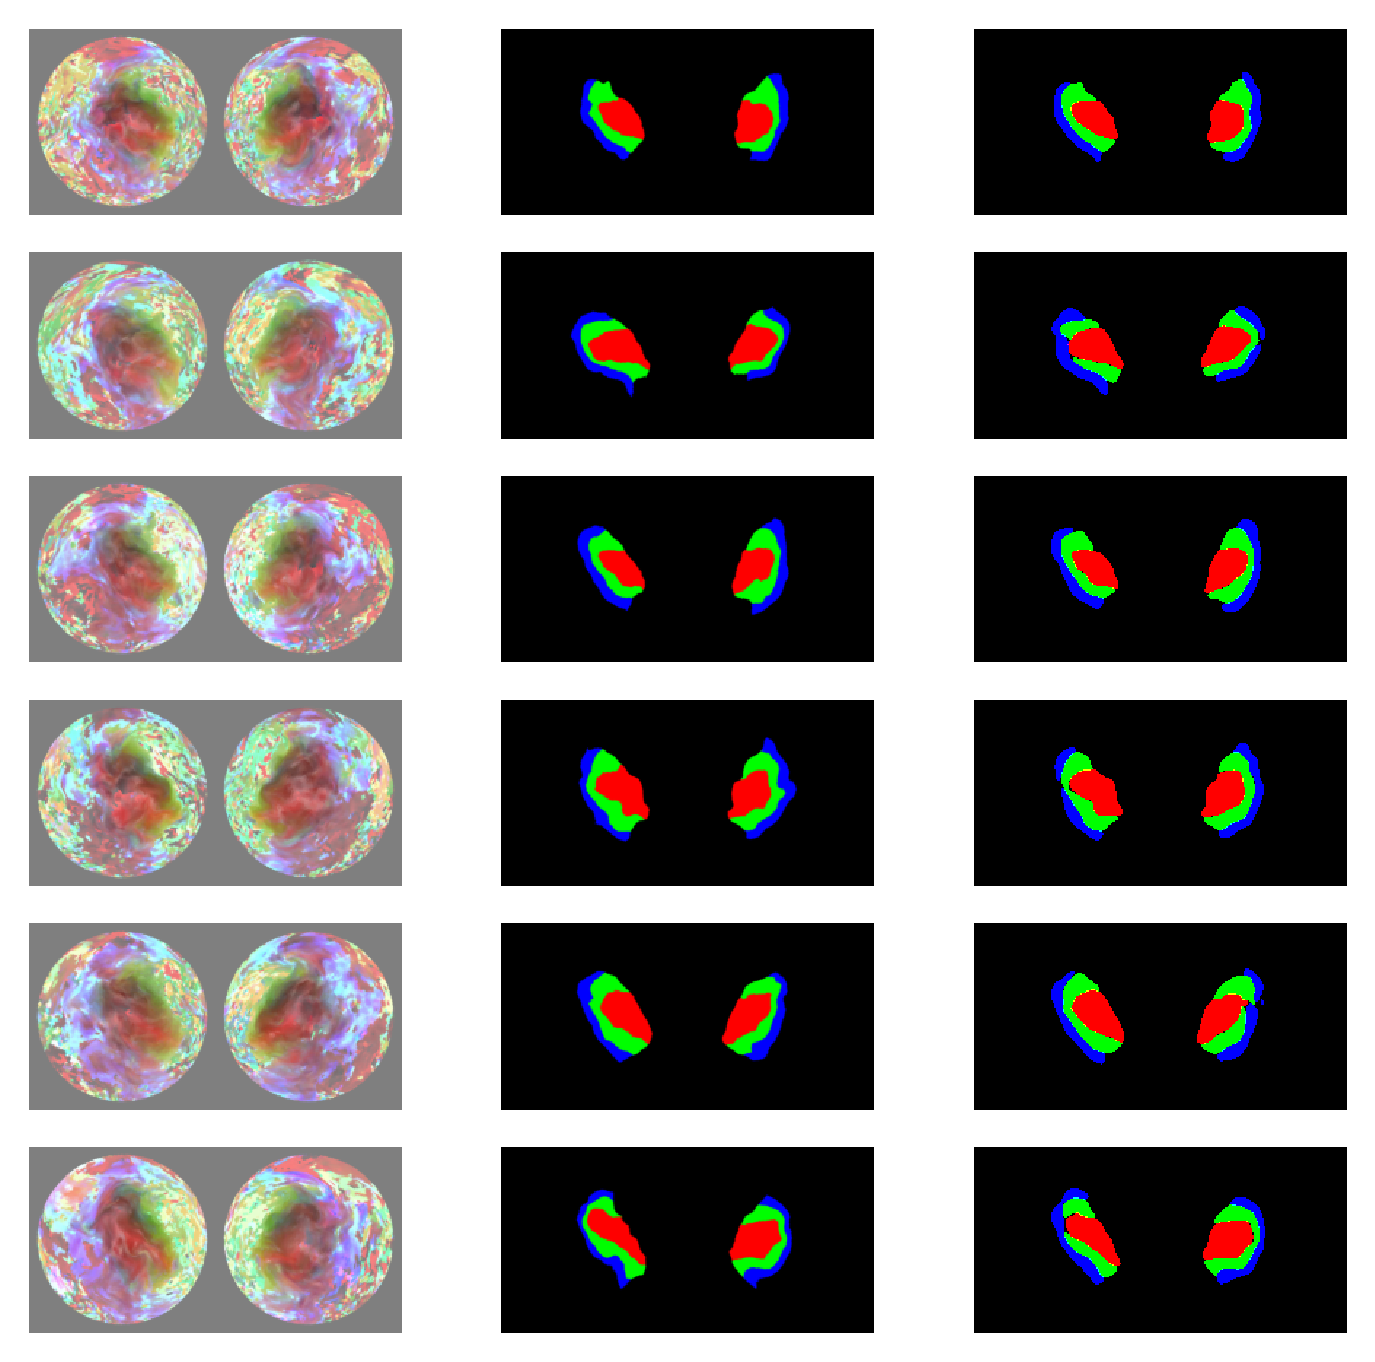

In [64]:
# Parameters
#------------------------------------------------------------------------------
# What feature-set do we want to plot?
features = 'func'
# What model are we plotting the results for?
model = models[features]
# Which subject-IDs (or subject indices, either one) are we plotting?
plot_subs = np.arange(6)
# Training or Validation data?
phase = 'val'
# What datasets are we using? (If None, then makes one using the default
# partition).
datasets = None

# Make the Figure
#------------------------------------------------------------------------------
# Make the datasets if need be.
if datasets is None:
    datasets = va.make_datasets(partition=(trn_sids, val_sids),
                                cache_path=data_cache_path)
# Make the figure and axes that we're going to use.
(fig,axs) = plt.subplots(len(plot_subs), 3,
                         figsize=(6, len(plot_subs)),
                         dpi=72*4)
# And plot each row using the `plot_prediction` function.
for (axrow,idx) in zip(axs, plot_subs):
    plot_prediction(datasets[features][phase], idx, model, axes=axrow)

### Accuracy Comparison

This code needs to be checked and updated.

In [222]:
func_model = trained_models['func'][0]
anat_model = trained_models['anat'][0]

func_ds = datasets['val']['func']
anat_ds = datasets['val']['anat']

def npdice(a,b):
    a = torch.tensor(a.T[:3])
    b = torch.tensor(b.T[:3])
    return 1 - dice_loss(a[None,:,:,:], b[None,:,:,:])
def subdice(ds, k, model):
    sid = ds.sids[k]
    (trnim, ansim) = ds[k]
    preim = torch.sigmoid(model(trnim[None,:,:,:].float()))
    preim = ds.inv_transform(None, preim.detach()[0])
    (trnim, ansim) = ds.inv_transform(trnim, ansim)
    infim = comparison_image(sid)
    priim = companat_image()
    return {'model': npdice(preim, ansim),
            'bayes': npdice(infim, ansim),
            'prior': npdice(priim, ansim)}
def alldice(ds, model):
    dat = [subdice(ds, k, model) for k in range(len(ds.sids))]
    res = []
    for (m,sid) in zip(dat, ds.sids):
        m = {k:v.detach().numpy() for (k,v) in m.items()}
        m['sid'] = sid
        res.append(m)
    return ny.util.to_dataframe(res)

In [223]:
d = alldice(anat_ds, anat_model)

In [224]:
{k: (np.mean(v), np.std(v)/np.sqrt(len(v)), np.median(v), np.percentile(v, 25), np.percentile(v, 75))
 for k in ['model','bayes','prior']
 for v in [d[k].values]}

{'model': (0.7586430125225625,
  0.008477384465692323,
  0.7724644373568392,
  0.7247349369185487,
  0.8021125891625124),
 'bayes': (0.7087995141025225,
  0.009643316660442929,
  0.7249986218068809,
  0.6947594585447514,
  0.7440246912721558),
 'prior': (0.6983875593065093,
  0.0077295654142980575,
  0.7006973293733195,
  0.6724228998098741,
  0.7331302495354244)}

### Hyper-parameter Grid Search

This code needs to be updated.

In [ ]:
grid_params = {
    'dataset': ['both'],
    'batch_size': [2,5,8],
    'lr': [0.01,0.005,0.00375,0.0025,0.00125],
    'gamma': [0.95, 0.9, 0.75, 0.5, 0.25],
    'pretrained_resnet': [True, False]}

grid = []
for (k,vs) in grid_params.items():
    if len(grid) == 0:
        grid = [{k:v} for v in vs]
    else:
        grid = [dict(u, **{k:v}) for u in grid for v in vs]

In [ ]:
import shutil

os.nice(10) # run these nicely!
cpath0 = os.path.join(resnet_path, 'grid')

for (ii,row) in enumerate(grid):
    if ii % 12 == 0:
        print("%3d of %-3d (%6.2f%%)" % (ii+1, len(grid), ii/(len(grid)-1)*100))
    tag = 'dat%04d' % (ii,)
    cpath = os.path.join(cpath0, tag)
    cfile = os.path.join(cpath0, tag + '.json')
    if os.path.isfile(cfile):
        for (k,v) in ny.load(cfile).items():
            row[k] = v
        continue
    mdl0 = resnet_model(pretrained=row['pretrained'])
    (mdl,loss,dice) = plan_to_model(mdl0, [row], cache_path=cpath, logger=None)
    row['tag'] = tag
    row['loss'] = loss
    row['dice'] = dice
    # Clear out the files that we don't need and resave the model and data
    ny.save(cfile, row)
    shutil.move(os.path.join(cpath,  'round01', 'optim000019.pkl'),
                os.path.join(cpath0, 'opt%04d.pkl' % ii))
    shutil.move(os.path.join(cpath,  'round01', 'model000019.pkl'),
                os.path.join(cpath0, 'mdl%04d.pkl' % ii))
    shutil.rmtree(cpath)    
    
grid = ny.to_dataframe(grid)